# Adaboost Implementation

The following code is friendly borrowed from [Jaime Pastor](https://github.com/jaimeps/adaboost-implementation/blob/master/adaboost.py). 

Go through the code and try to understand what each function is doing. Don't forget to write some comments or add a docstring to the functions. 

In [1]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_hastie_10_2           # make_hastie_10_2 generates a data set for binary classification 
import matplotlib.pyplot as plt

In [2]:
""" HELPER FUNCTION: GET ERROR RATE ========================================="""
def get_error_rate(pred, Y):
    return sum(pred != Y) / float(len(Y))

""" HELPER FUNCTION: PRINT ERROR RATE ======================================="""
def print_error_rate(err):
    print ('Error rate: Training: %.4f - Test: %.4f' % err)

""" HELPER FUNCTION: GENERIC CLASSIFIER ====================================="""
def generic_clf(Y_train, X_train, Y_test, X_test, clf):
    clf.fit(X_train,Y_train)
    pred_train = clf.predict(X_train)
    pred_test = clf.predict(X_test)
    return get_error_rate(pred_train, Y_train), \
           get_error_rate(pred_test, Y_test)

In [3]:
""" ADABOOST IMPLEMENTATION ================================================="""
def adaboost_clf(Y_train, X_train, Y_test, X_test, M, clf):
    n_train, n_test = len(X_train), len(X_test)
    # 
    w = np.ones(n_train) / n_train
    pred_train, pred_test = [np.zeros(n_train), np.zeros(n_test)]
    
    for i in range(M):
        # 
        clf.fit(X_train, Y_train, sample_weight = w)
        pred_train_i = clf.predict(X_train)
        pred_test_i = clf.predict(X_test)
        # 
        miss = [int(x) for x in (pred_train_i != Y_train)]
        # 
        miss2 = [x if x==1 else -1 for x in miss]
        # 
        err_m = np.dot(w,miss) / sum(w)
        # 
        alpha_m = 0.5 * np.log( (1 - err_m) / float(err_m))
        # 
        w = np.multiply(w, np.exp([float(x) * alpha_m for x in miss2]))
        # 
        pred_train = [sum(x) for x in zip(pred_train, 
                                          [x * alpha_m for x in pred_train_i])]
        pred_test = [sum(x) for x in zip(pred_test, 
                                         [x * alpha_m for x in pred_test_i])]
    
    pred_train, pred_test = np.sign(pred_train), np.sign(pred_test)
    # 
    return get_error_rate(pred_train, Y_train), \
           get_error_rate(pred_test, Y_test)

In [4]:

""" PLOT FUNCTION ==========================================================="""
def plot_error_rate(er_train, er_test):
    df_error = pd.DataFrame([er_train, er_test]).T
    df_error.columns = ['Training', 'Test']
    plot1 = df_error.plot(linewidth = 3, figsize = (8,6),
            color = ['lightblue', 'darkblue'], grid = True)
    plot1.set_xlabel('Number of iterations', fontsize = 12)
    plot1.set_xticklabels(range(0,450,50))
    plot1.set_ylabel('Error rate', fontsize = 12)
    plot1.set_title('Error rate vs number of iterations', fontsize = 16)
    plt.axhline(y=er_test[0], linewidth=1, color = 'red', ls = 'dashed')



/var/folders/jc/_qryt33s7tz7rjc72ygnp87c0000gn/T/ipykernel_1770/3828118058.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  plot1.set_xticklabels(range(0,450,50))


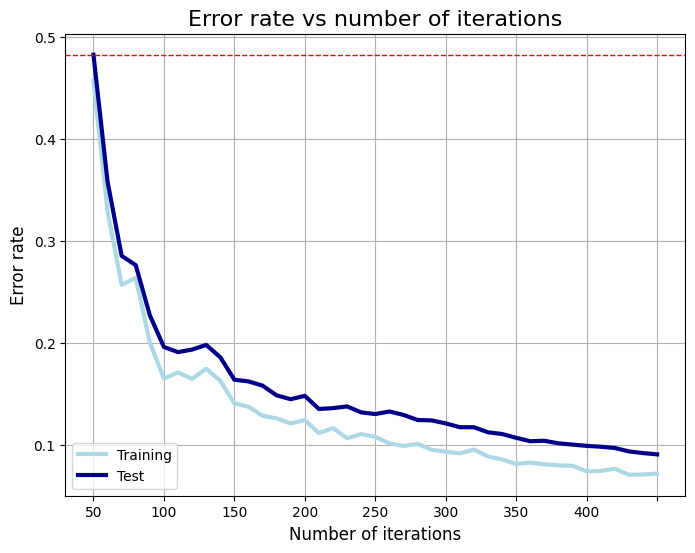

In [5]:
""" MAIN SCRIPT ============================================================="""
if __name__ == '__main__':
    
    # Read data
    x, y = make_hastie_10_2()
    df = pd.DataFrame(x)
    df['Y'] = y

    # Split into training and test set
    train, test = train_test_split(df, test_size = 0.2)
    X_train, Y_train = train.iloc[:,:-1], train.iloc[:,-1]
    X_test, Y_test = test.iloc[:,:-1], test.iloc[:,-1]
    
    # Fit a simple decision tree first
    clf_tree = DecisionTreeClassifier(max_depth = 1, random_state = 1)
    er_tree = generic_clf(Y_train, X_train, Y_test, X_test, clf_tree)
    
    # Fit Adaboost classifier using a decision tree as base estimator
    # Test with different number of iterations
    er_train, er_test = [er_tree[0]], [er_tree[1]]
    x_range = range(10, 410, 10)
    for i in x_range:    
        er_i = adaboost_clf(Y_train, X_train, Y_test, X_test, i, clf_tree)
        er_train.append(er_i[0])
        er_test.append(er_i[1])
    
    # Compare error rate vs number of iterations
    plot_error_rate(er_train, er_test)